### 1. Quick EDA and cleaning
### 2. Baseline with HistGradientBoostingClassifier
### 3. Initial Scoring of Classifiers
### 4. Hyperparams Tuning
### 5. Voting Ensemble

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

### 1. Data


In [3]:
data = pd.read_csv("data/comp_df.csv")

In [4]:
data.head()

,job_name,hours,remote,company_name,education,seniority,language,city,country,job_published_at,sample_date,comp_dol,all_tags
0,seniorprincipal engineer electrical,Full-Time,Unclear,0887 DS,Bachelors,Staff IC,en,NaN,United States,2023-04-17,2023,154800,Serverless Sigma Tools
1,lead algorithm engineer,Full-Time,Unclear,1000 KLA Corporation,Masters,Unclear Seniority,en,Ann Arbor,United States,2023-05-23,2023,123100,Linux ML Languages eCom OSS Stat OS C MATLAB T...
2,information technology support engineer,Full-Time,Unclear,Addnectar Solutions,Bachelors,Junior IC,en,Mumbai,India,2023-02-14,2024,28915,IT
3,systems and software development specialist,Full-Time,Unclear,Forge Group,Bachelors,Unclear Seniority,en,Reston,United States,2023-05-30,2023,95000,Hosting OSS PaaS Service Science App Stack Gov...
4,senior machine learning engineer,Full-Time,Unclear,260312-SOUTH FLORIDA REGION ADMIN,Unclear,Senior IC,en,Jersey City,United States,2024-02-27,2024,203625,OSS Stat Python Java Tools Languages PaaS IaaS...


In [5]:
import missingno as msno
%matplotlib inline

<Axes: >

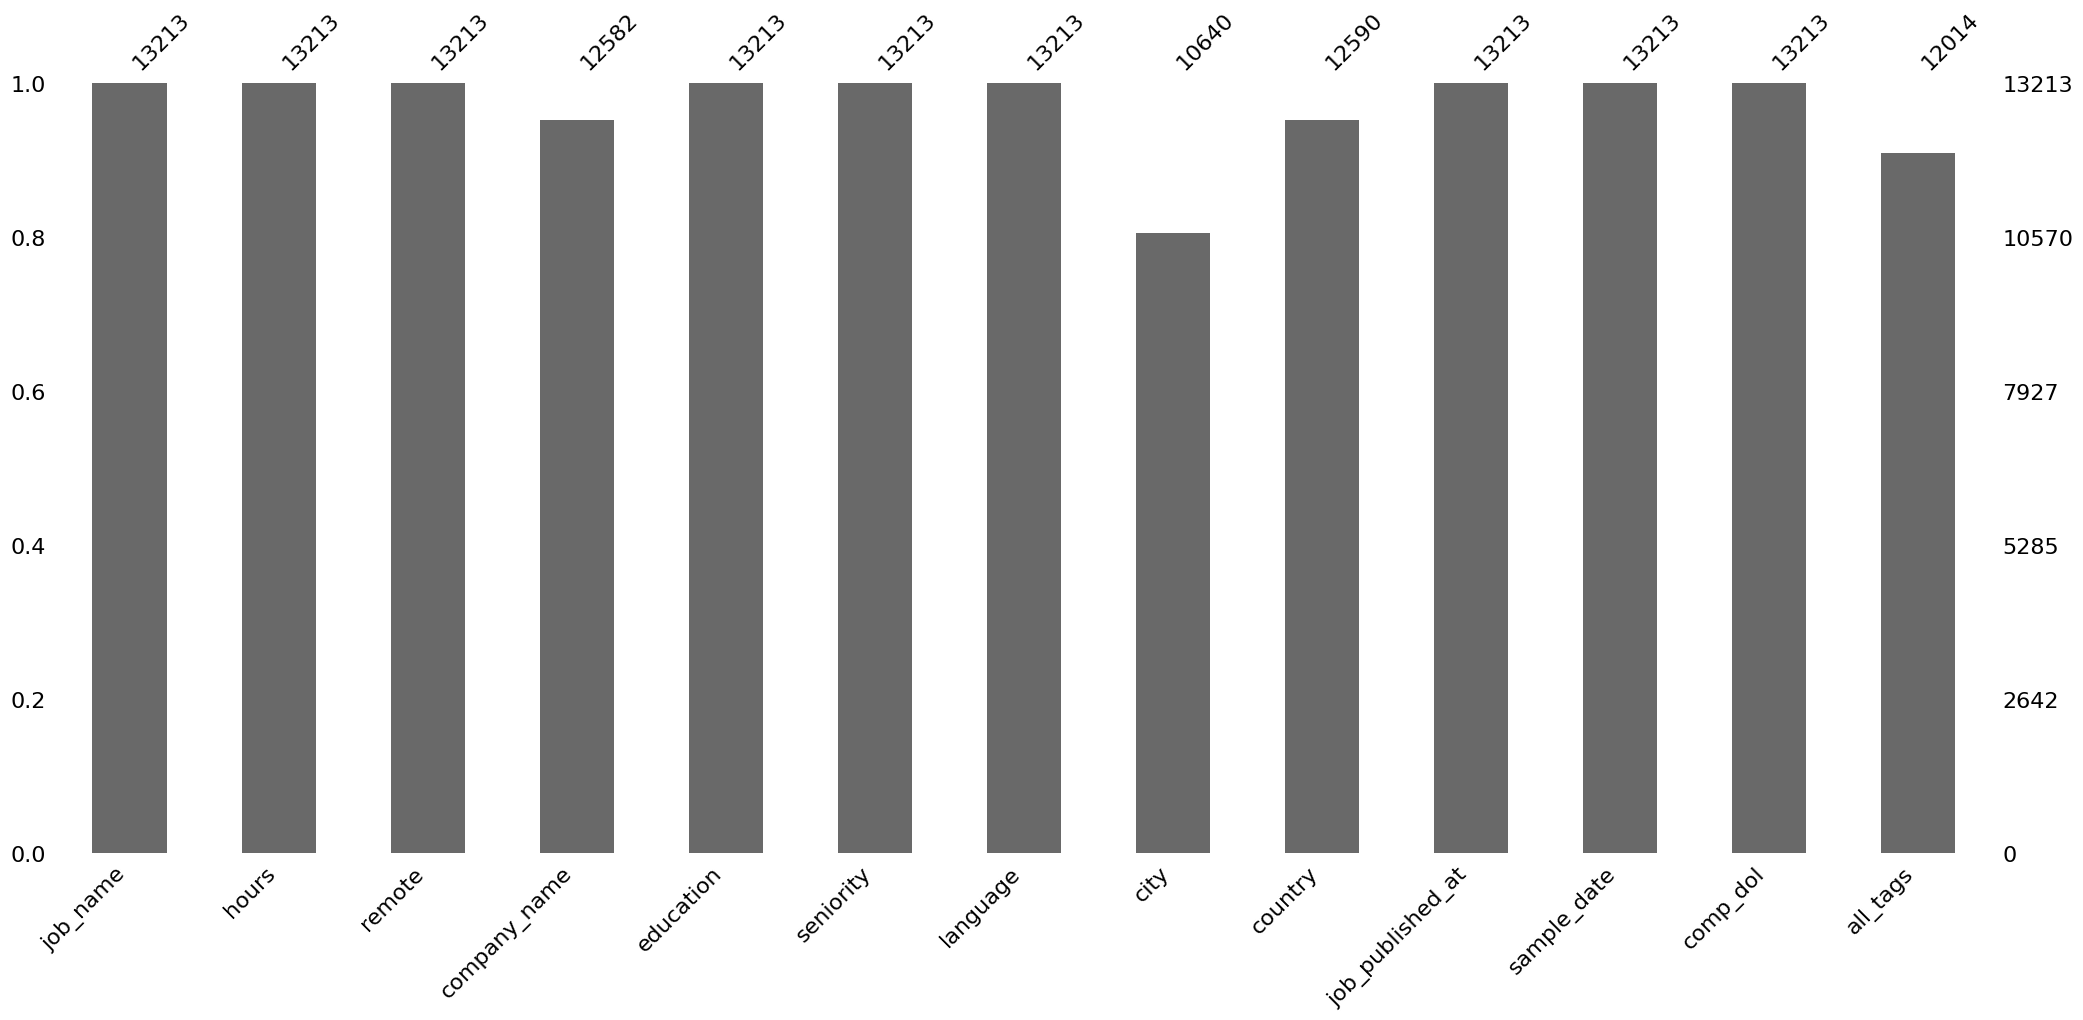

In [6]:
msno.bar(data)

In [7]:
data.dropna(inplace=True)

<Axes: >

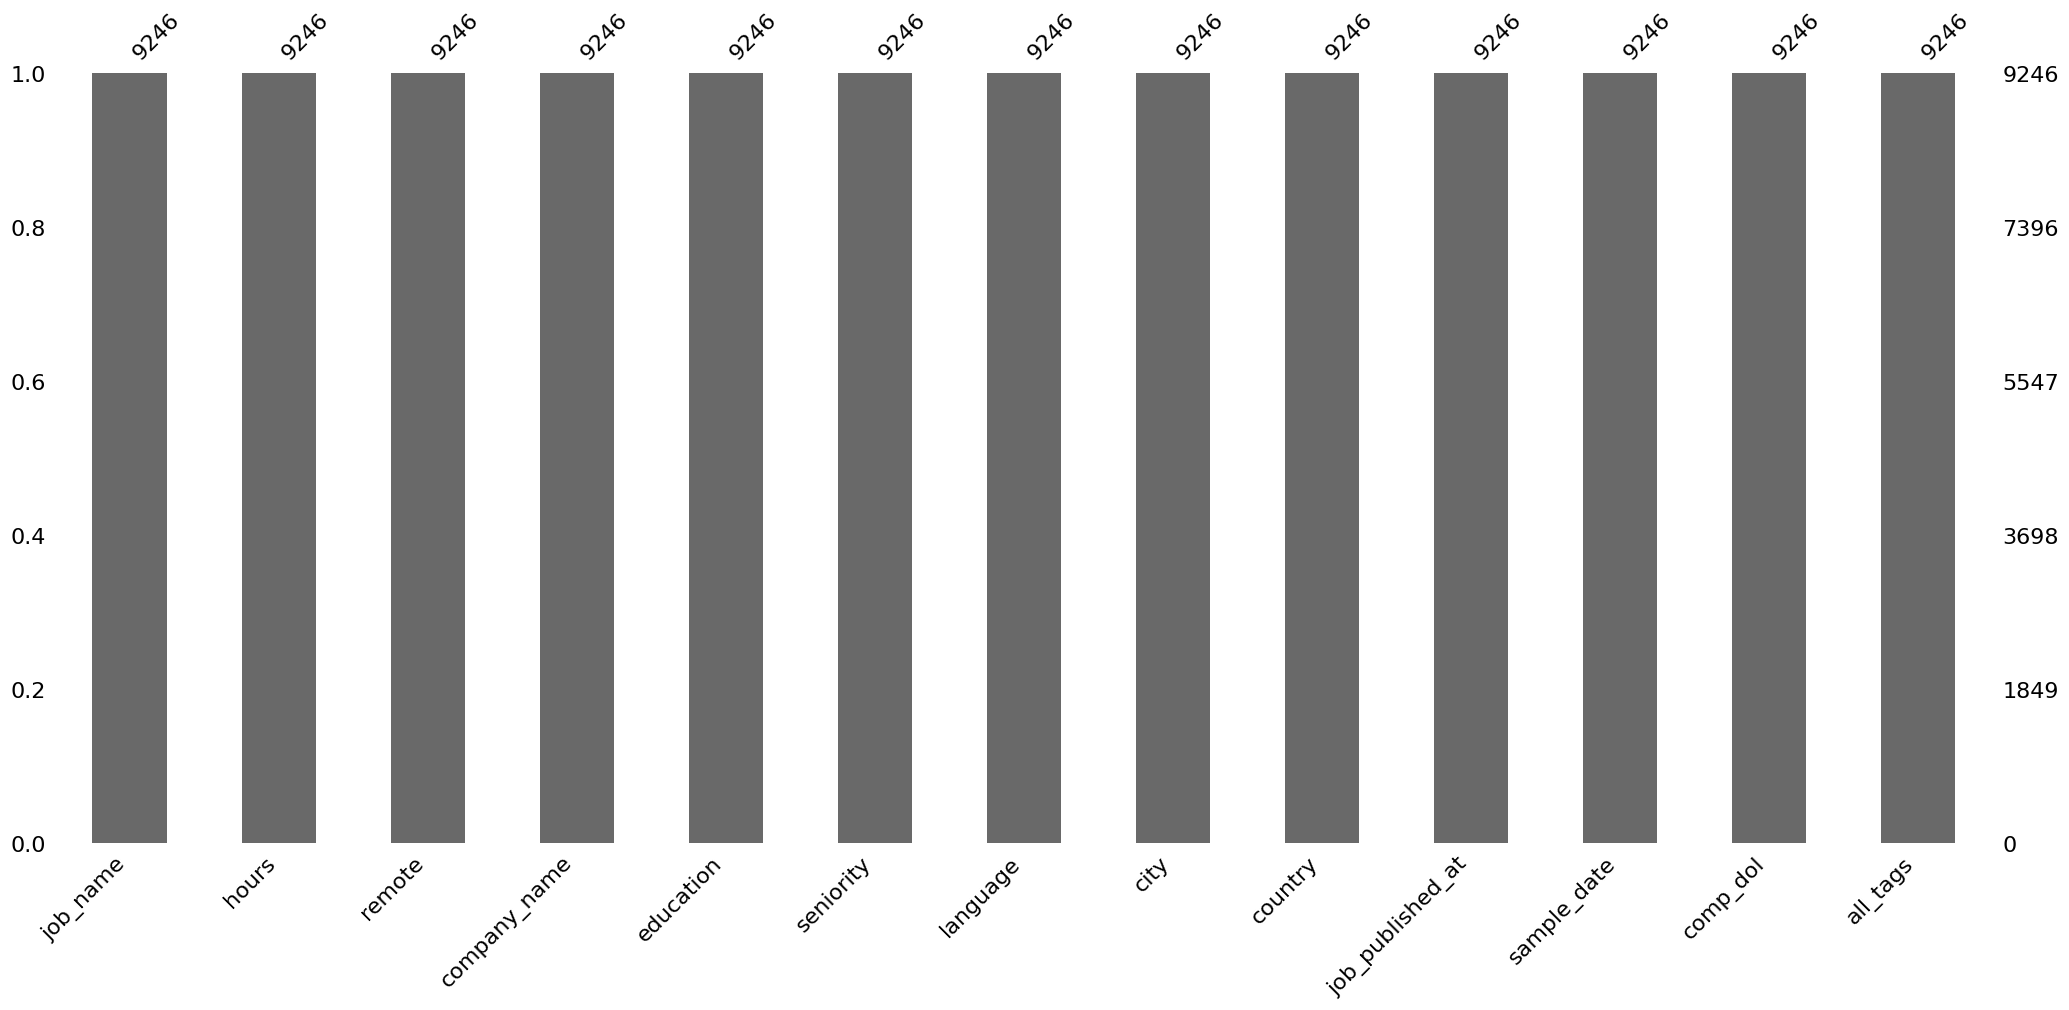

In [8]:
msno.bar(data)

In [9]:
cat_type = ["hours","remote","education","seniority", "country", "sample_date"]
str_type = ["job_name", "all_tags"]
int_type = ["comp_dol"]

In [10]:
def cast_types(df):
    for col in df.columns:
        if col in cat_type:
            df[col] = df[col].astype("category")
        if col in str_type:
            df[col] = df[col].astype("str")
        if col in int_type:
            df[col] = df[col].astype("int64")


In [11]:
cast_types(data)

In [12]:
data.dtypes

job_name              object
hours               category
remote              category
company_name          object
education           category
seniority           category
language              object
city                  object
country             category
job_published_at      object
sample_date         category
comp_dol               int64
all_tags              object
dtype: object

### 2. Baseline with different Regressors
#### Using HistGradientBoostingClassifier to get an initial idea of my pipeline and baseline results

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import  Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, KFold
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_predict, ValidationCurveDisplay, learning_curve
from sklearn.metrics import make_scorer, mean_squared_error,  mean_absolute_error, r2_score 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn import svm

In [75]:
scaler = StandardScaler()
X = data.drop(columns=["comp_dol"]) #all_tags
y = data[["comp_dol"]]
y_trans = scaler.fit_transform(y)
kf = KFold(n_splits=5, shuffle = True, random_state = 2137)
X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size = 0.2, shuffle=True, random_state = 2137)

In [76]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return np.asarray(X.todense())

In [77]:
col_transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), cat_type),
    (CountVectorizer(stop_words="english"), "job_name"),
    (CountVectorizer(stop_words="english"), "all_tags"),   
)

### 3. Initial Scoring of Classifiers
#### Let's try different estimators and compare their results

In [78]:
models = [
    ('xgb', XGBRegressor(verbose=0)),
    ('lgbm', LGBMRegressor(verbosity=-1)),
    ('cat', CatBoostRegressor(silent=True)),
    ('svr_lin', svm.SVR(kernel="linear")),
    ('svr_rbf', svm.SVR(kernel="rbf")),
    ('sgd', SGDRegressor(loss='squared_error', penalty='l2')),
    ('rf', RandomForestRegressor()),
]

In [79]:
metrics={
    'mse':make_scorer(mean_squared_error),
    'mae':make_scorer(mean_absolute_error), 
    'r2':make_scorer(r2_score)
}

In [80]:
def build_pipes(models, column_transformer):
    pipes = {}
    for model in models:
        pipe = Pipeline(steps = [('data_prep', col_transformer), model], verbose=False)
        pipes[model[0]] = pipe
    return pipes

In [81]:
def score_cv(estimators=pipes,n_splits=5,metrics=metrics):
    scorers=[]
    for pipe_name in pipes.keys():
        pipe=pipes[pipe_name]
        labels.append(pipe_name)
        kf = KFold(n_splits)
        model_score=cross_validate(pipe, X_train, y_train, scoring=metrics, cv=kf)
        scorers.append(model_score)
    
    score_lists={}
    for metric in metrics:
        score_lists[metric] = [score['test_' + metric] for score in scorers]
        
    return score_lists


In [82]:
def plot_scores(score_lists, labels):
    for  i,(title, list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot=sns.boxplot(data=list, palette='hls').set_xticklabels(labels, rotation=45)
        plt.title(title)
        plt.savefig("plots/" + title+'_score.png', dpi=150)

In [ ]:
def plot_learning_curves(pipelines):
    for clf_name in pipes.keys():
        train_size_abs, train_scores, test_scores = learning_curve(
        pipes[clf_name], X_train, y_train, train_sizes=[0.2, 0.4, 0.6, 0.8, 1], cv=kf, scoring='r2')
    
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
    
        plt.figure(figsize=(10, 6))
        plt.plot(train_size_abs, train_mean, label="Training score", color="darkcyan", marker='o')
        plt.fill_between(
            train_size_abs,
            train_mean - train_std,
            train_mean + train_std,
            alpha=0.1,
            color="aqua",
        )
        plt.plot(train_size_abs, test_mean, label="Test score", color="mediumorchid", marker='o')
        plt.fill_between(
            train_size_abs,
            test_mean - test_std,
            test_mean + test_std,
            alpha=0.1,
            color="fuchsia",
        )

        plt.xlabel("Number of training samples")
        plt.ylabel("Score")
        plt.title(clf_name + "_learning curves R2")
        plt.legend(loc="best")
        plt.grid(True)
        plt.savefig(clf_name + "curves R2.png")
        plt.show()
    

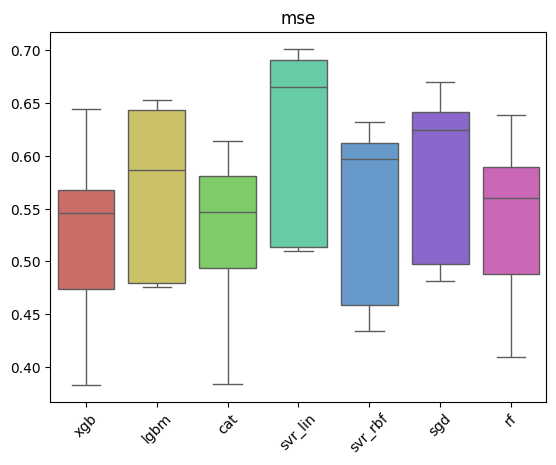

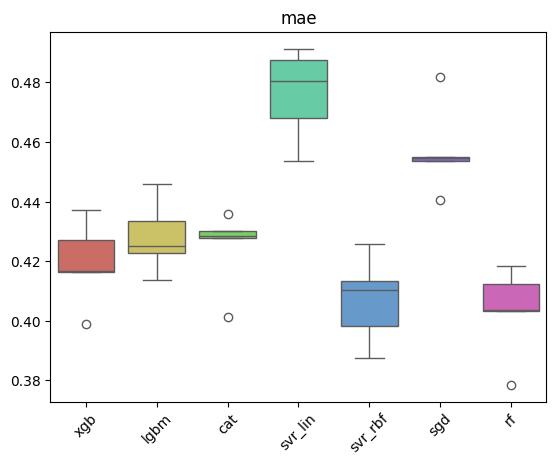

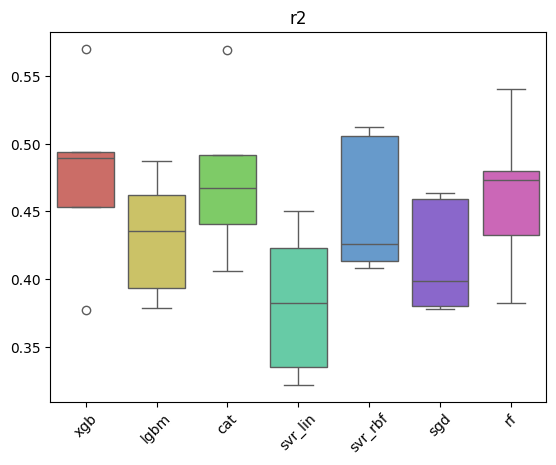

In [83]:
pipes = build_pipes(models, col_transformer)
score_lists = score_cv()
labels = pipes.keys()
plot_scores(score_lists, labels)

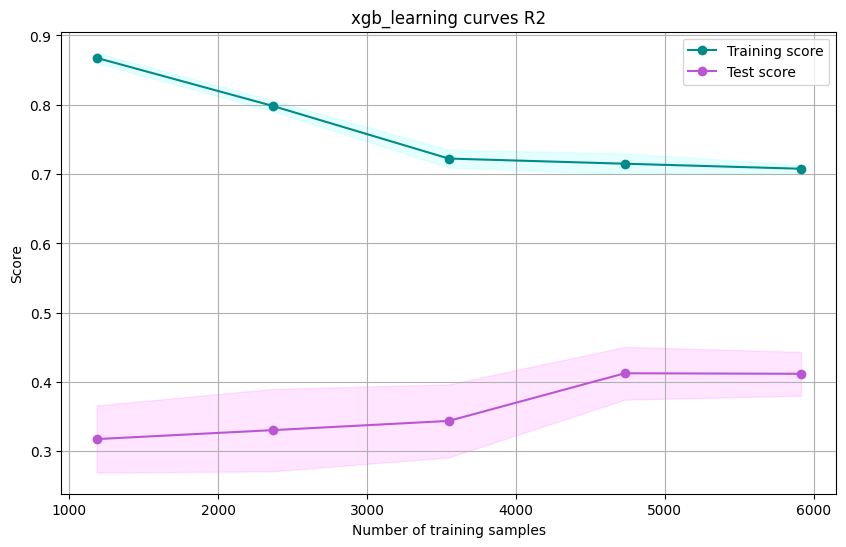

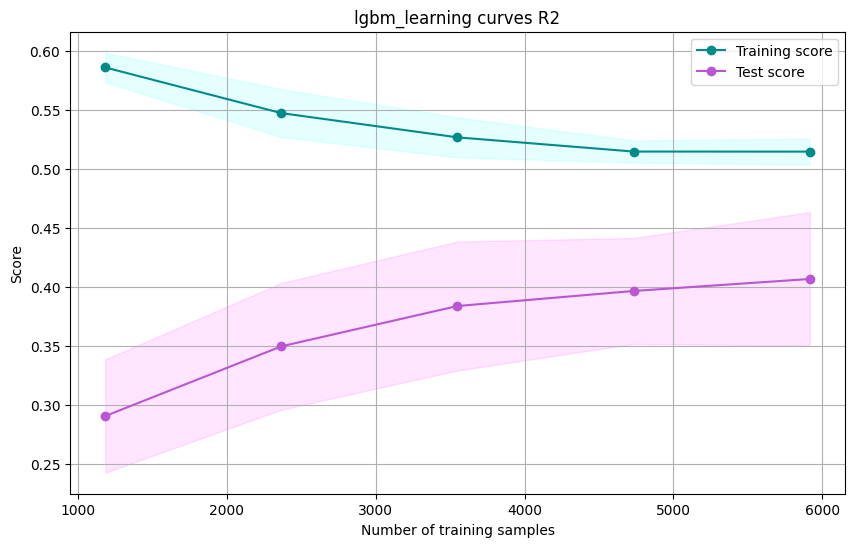

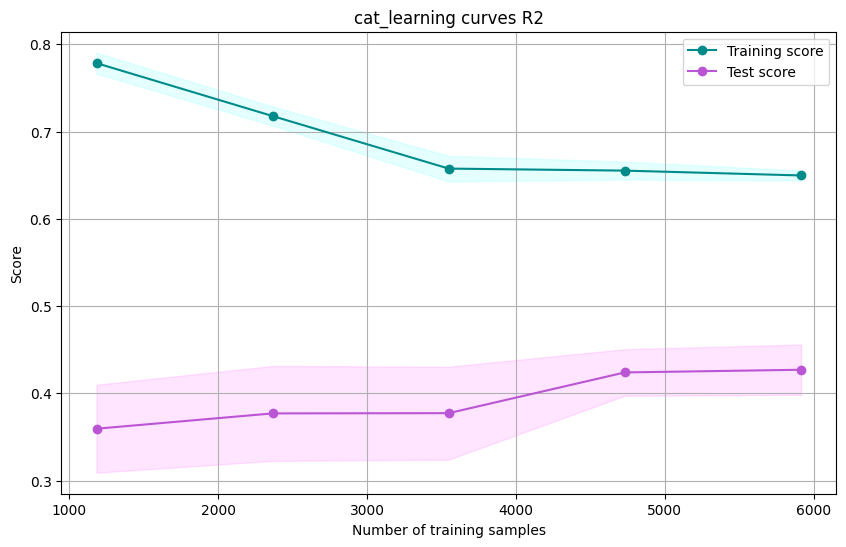

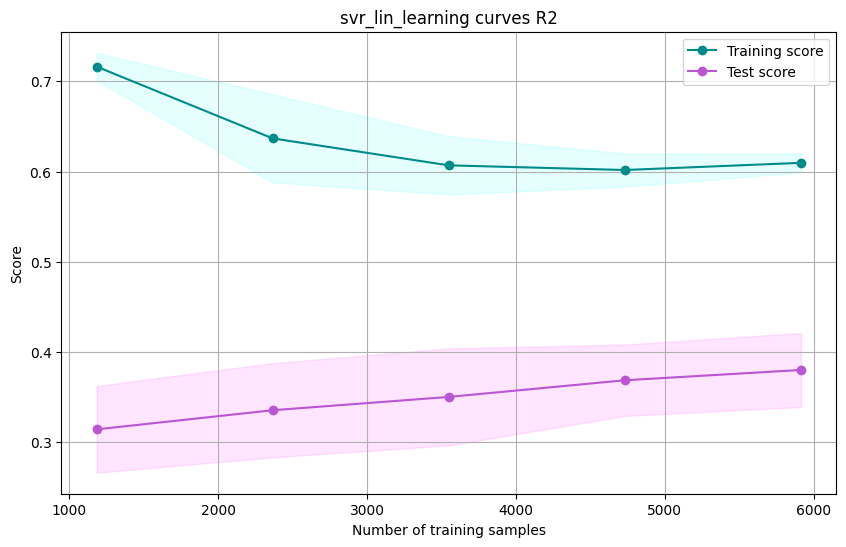

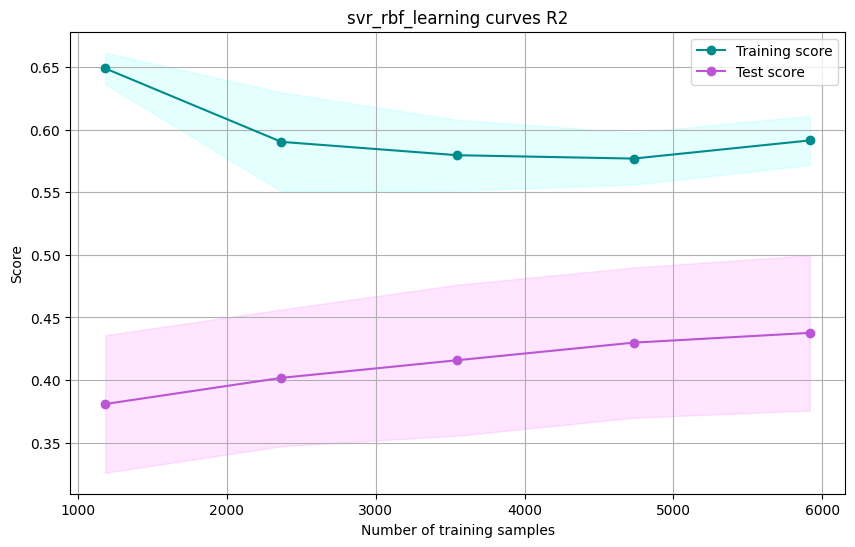

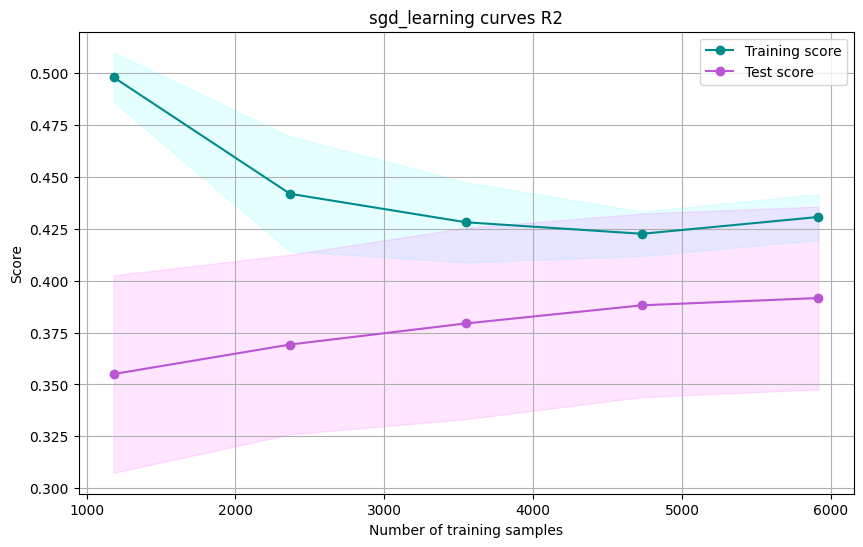

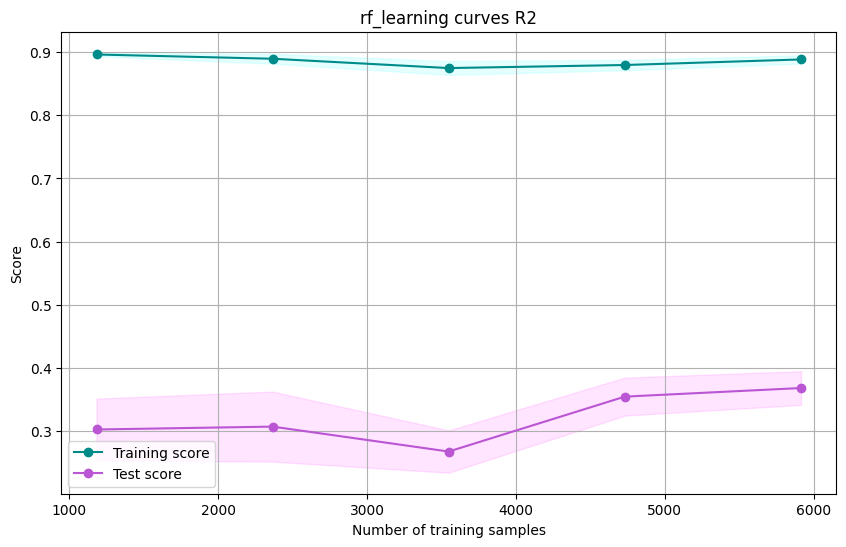

In [31]:
plot_learning_curves(pipes)

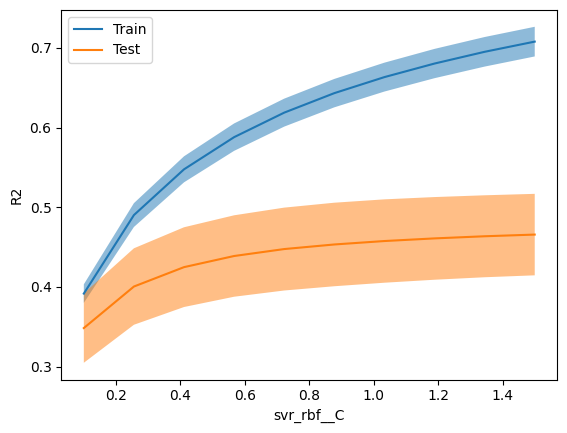

In [84]:
ValidationCurveDisplay.from_estimator(
   pipes['svr_rbf'], X_train, y_train, param_name='svr_rbf__C', param_range=np.linspace(0.1, 1.5, 10),  cv=kf, scoring='r2'
)